# Анализ и построение модели прогнозирования качества и продуктивности молочных коров для оптимизации отбора поголовья для компании "Вольный луг".



### Цели исследования

- Анализ предоставленных данных и выявление ключевых факторов.


- Разработка модели машинного обучения для прогнозирования годового удоя молока.


- Разработка модели машинного обучения для оценки качества молока.


- Оптимизировать и создать надежный алгоритм призванный упростить процесс покупки нового поголовья коров.



### Процесс исследования

- Загрузка предоставленных нам данных и первичное ознакомление с ними.


- Обработка пропусков и дубликатов в данных , а так же поиск аномалий и улучшение качества данных.


- Исследование данных с целью выявление необходимых нам для построения модели **МО** закономерностей.


- Построение моделей **МО** на обработанных данных и оценка успешности их работы.


- Итоговый вывод и рекомендации по приобретению новых коров для фирмы "Вольный луг".


### Описание полученных данных

#### ferma_main.csv

`id` — уникальный идентификатор коровы.

`Удой`, кг — масса молока, которую корова даёт в год (в килограммах).

`ЭКЕ` (Энергетическая кормовая единица) — показатель питательности корма коровы.

`Сырой протеин` г — содержание сырого протеина в корме (в граммах).

`СПО` (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.

`Порода` — порода коровы.

`Тип пастбища` — ландшафт лугов, на которых паслась корова.

`порода папы_быка` — порода папы коровы.

`Жирность`% — содержание жиров в молоке (в процентах).

`Белок`% — содержание белков в молоке (в процентах).

`Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).

`Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).


#### ferma_dad.csv

`id` — уникальный идентификатор коровы.

`Имя Папы` — имя папы коровы.


#### cow_buy.csv

`Порода` — порода коровы.

`Тип пастбища` — ландшафт лугов, на которых паслась корова.

`порода папы_быка` — порода папы коровы.

`Имя_папы` — имя папы коровы.

`Текущая_жирность`% — содержание жиров в молоке (в процентах).

`Текущий_уровень_белок`% — содержание белков в молоке (в процентах).

`Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

### Импорт необходимых для выполнения исследования библиотек.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import phik
from IPython.display import display, HTML
from scipy.stats import binom, norm
from scipy import stats as st
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, \
    recall_score, confusion_matrix, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder


### Создание необходимых нам функций.

In [3]:
sns.set_style('whitegrid')
sns.set_palette('RdYlBu')
def graph_cat(df, columns, title, xlabel):
    """
    Визуализирует категориальные данные с помощью круговой диаграммы и столбчатой диаграммы.

    Параметры:
    -----------
    df : pandas.DataFrame
        DataFrame, содержащий данные.
    columns : str
        Название столбца с категориальными данными для визуализации.
    title : str
        Заголовок графика.
    xlabel : str
        Подпись оси X.

    
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    df[columns].value_counts().plot(kind='pie', y='count', x='subscription_type',
                           colors=['grey', 'orange', 'lightblue', 'yellow'],ax=ax[0], autopct='%1.1f%%')
    ax[0].set_title('Процентное ' + title)
    ax[0].set_ylabel(' ')

    sns.countplot(data=df, y=columns, ax=ax[1], palette=['grey', 'orange', 'lightblue', 'yellow'])
    #sns.countplot(data=df, x=columns, ax=ax[1], palette=['grey', 'orange', 'lightblue'], orient='h')
    ax[1].set_title('Колличественное '+ title)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Количество')

def graph_num(df, columns, title, xlabel, bins=30):
    """
    Визуализирует числовые данные с помощью гистограммы и boxplot.

    Параметры:
    -----------
    df : pandas.DataFrame
        DataFrame, содержащий данные для анализа.
    columns : str
        Название столбца с числовыми данными, которые будут визуализированы.
    title : str
        Заголовок графика (добавляется к описанию гистограммы и boxplot).
    xlabel : str
        Подпись оси X для гистограммы.
    bins : int, optional
        Количество интервалов (бинов) для гистограммы. По умолчанию 30.

    
    """
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    sns.histplot(data=df, x=columns, kde=True, color='blue', bins=bins, ax=ax[0])
    ax[0].set_title('Гистограмма признака '+ title)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('Кол-во')
    
    sns.boxplot(data=df[columns], orient='h', ax=ax[1])
    ax[1].set_title('Разброс значений признака '+ title)
    ax[1].set_xlabel('Значения')
    ax[1].set_ylabel(' ')

def graph_scat(df, categorical_feature):
    """
    Функция для построения scatterplots по 2 графика в строке.
    
    Параметры:
    - df: DataFrame с данными.
    - categorical_feature: Имя категориального признака (например, 'breed').
    """
    features = ['efu', 'raw_protein', 'spr', 'fat', 'protein']
    
    n_rows = (len(features) // 2 + (len(features) % 2 > 0))  
    
    fig, axes = plt.subplots(n_rows, 2, figsize=(16, 6 * n_rows))
    fig.tight_layout(pad=5.0)  
    
    for i, feature in enumerate(features):
        ax = axes[i // 2, i % 2]  
        sns.scatterplot(
            x=df['milk_yeild'],  
            y=df[feature],        
            hue=df[categorical_feature],  
            palette='Set1',       
            s=100,                
            alpha=0.8,            
            ax=ax                 
        )
        ax.set_title(f'Зависимость между Удой, кг и {feature}', fontsize=14)
        ax.set_xlabel('Удой, кг', fontsize=12)
        ax.set_ylabel(feature, fontsize=12)
        ax.legend(title=categorical_feature, title_fontsize=12, fontsize=10)
        ax.grid(True)  
    
    # Если количество признаков нечетное, удаляем пустой subplot
    if len(features) % 2 != 0:
        fig.delaxes(axes[-1, -1])
    
    plt.show()

# def model_score(y_test, y_pred, num):
#     mse = mean_squared_error(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
#     rmse = mean_squared_error(y_test, y_pred, squared=False)
#     print(f'MSE модели №{num} : {mse} ')
#     print(f'MAE модели №{num} : {mae}')
#     print(f'RMSE модели №{num} : {rmse}')

def model_score(y_test, y_pred, num):
    # Вычисляем метрики
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    # Создаем датафрейм с результатами
    metrics_df = pd.DataFrame({
        'Model': [f'Model {num}'],
        'MSE': [mse],
        'MAE': [mae],
        'RMSE': [rmse]
    })
    
    return metrics_df

## Загрузка данных

**Поочередно загрузим присланные из компаний «Вольный луг» и «ЭкоФерма» данные и проведем первичное ознакомление.**

### Набор данных ferma_main который содержит данные о стаде фермера на текущий момент. 

In [4]:
df_main = pd.read_csv('/datasets/ferma_main.csv', sep=';')
display(df_main.head(5))
display(df_main.describe().T)
df_main.info()

id  Удой, кг ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                  14,2              1743   
1   2      5529                                  12,8              2138   
2   3      5810                                    14              1854   
3   4      5895                                  12,4              2012   
4   5      5302                                  12,8              1675   

  СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0,89   Вис Бик Айдиал    Равнинное   
1                                 0,89   Вис Бик Айдиал    Равнинные   
2                                0,885  РефлешнСоверинг    Холмистое   
3                                0,885  РефлешнСоверинг    Холмистое   
4                                0,885   Вис Бик Айдиал    Равнинные   

  порода папы_быка Жирность,% Белок,% Вкус молока      Возраст  
0           Айдиал       3,58   3,076      вкусно  более_2_лет  
1          Соверин       3,54   3,079      вкусно  менее_2_лет  
2          Соверин       3,59   3,074   не вкусно  более_2_лет  
3           Айдиал        3,4   3,075   не вкусно  более_2_лет  
4          Соверин       3,73   3,073      вкусно  менее_2_лет

count         mean          std     min      25%     50%  \
id                634.0   317.460568   183.096982     1.0   159.25   317.5   
Удой, кг          634.0  6187.025237  1638.401021  5204.0  5751.75  6130.5   
Сырой протеин, г  634.0  1922.682965   182.392548  1660.0  1772.25  1880.5   

                      75%      max  
id                 475.75    629.0  
Удой, кг          6501.00  45616.0  
Сырой протеин, г  2058.75   2349.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

В загруженном датафрейме в описании переменных наблюдается разный регистр и язык записи. Так же некоторые переменные представлены в несоответствующем для них типе данных. Так же максимальное значение удоя в **45616**кг вызывает подозрения.

### Набор данных ferma_dad в котором хранится имя папы каждой коровы в стаде фермера. 

In [5]:
df_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
display(df_dad.head(5))
display(df_dad.describe().T)
df_dad.info()

id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин

count   mean        std  min    25%    50%    75%    max
id  629.0  315.0  181.72094  1.0  158.0  315.0  472.0  629.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


В данные так же как и в предыдущем случае , столбцы представлены в разном стиле.

### Набор данных cow_buy содержатит информацию о коровах «ЭкоФермы».

In [6]:
df_cow = pd.read_csv('/datasets/cow_buy.csv', sep=';')
display(df_cow.head(5))
display(df_cow.describe().T)
df_cow.info()

Порода Тип пастбища порода папы_быка  Имя_папы Текущая_жирность,%  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес               3,58   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный               3,54   
2  РефлешнСоверинг    равнинное          Соверин     Барин               3,59   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный                3,4   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный               3,64   

  Текущий_уровень_белок,%      Возраст  
0                   3,076  более_2_лет  
1                   3,081  менее_2_лет  
2                   3,074  более_2_лет  
3                   3,061  более_2_лет  
4                   3,074  более_2_лет

count unique              top freq
Порода                     20      2  РефлешнСоверинг   11
Тип пастбища               20      2        равнинное   11
порода папы_быка           20      2          Соверин   12
Имя_папы                   20      4           Буйный    8
Текущая_жирность,%         20     12              3,4    3
Текущий_уровень_белок,%    20     12            3,074    5
Возраст                    20      2      более_2_лет   15

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


Так же как и в других наборах данных , стиль записи столбцов различаеться , а так же некотоые количественные переменные представленны типом данных `object`. 

### Вывод

- Во всех полученных и загруженным нами данных обнаружился один и тот же дефект , переменные записаны с применением разных языков и регистров , а так же некоторые количественные переменные записаны не подходящим для них типом данных. На этапе предобработки приведем столбцы к единому стилю записи и соответствующим типам данных. При первом ознакомлении других аномалий выявлено не было.


##  Предобработка данных

На этапе загрузки в данных обнаружились некоторые проблемы. В этом блоке мы устраним дефекты входных данных , а так же изучим наличие пропусков и дубликатов.

### Датафрейм `df_main`

#### Переведем названия столбцов на английский язык с использованием нижнего регистра.

In [7]:
df_main.columns = ['id', 'milk_yeild','efu', 'raw_protein', 'spr',
                   'breed', 'pasture', 'dad_type', 'fat', 'protein', 'taste', 'age_gr']
df_main.head(5)

id  milk_yeild   efu  raw_protein    spr            breed    pasture  \
0   1        5863  14,2         1743   0,89   Вис Бик Айдиал  Равнинное   
1   2        5529  12,8         2138   0,89   Вис Бик Айдиал  Равнинные   
2   3        5810    14         1854  0,885  РефлешнСоверинг  Холмистое   
3   4        5895  12,4         2012  0,885  РефлешнСоверинг  Холмистое   
4   5        5302  12,8         1675  0,885   Вис Бик Айдиал  Равнинные   

  dad_type   fat protein      taste       age_gr  
0   Айдиал  3,58   3,076     вкусно  более_2_лет  
1  Соверин  3,54   3,079     вкусно  менее_2_лет  
2  Соверин  3,59   3,074  не вкусно  более_2_лет  
3   Айдиал   3,4   3,075  не вкусно  более_2_лет  
4  Соверин  3,73   3,073     вкусно  менее_2_лет

Мы заменили **ЭКЕ (Энергетическая кормовая единица)** на **efu (Energy Feed Unit)** . а **СПО (Сахаро-протеиновое соотношение)** на **spr (Sugar-protein ratio)**. Все остальные переменные ссответсвуют своему прямому переводу на англ. язык.

Преобразуем переменные `efu spr fat protein` содержащие количественые данные в подходящий тип данных.

In [8]:
df_main = df_main.replace(',', '.', regex=True)
df_main[['efu', 'spr', 'fat', 'protein']] = df_main[['efu', 'spr', 'fat', 'protein']].apply(pd.to_numeric)
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           634 non-null    int64  
 1   milk_yeild   634 non-null    int64  
 2   efu          634 non-null    float64
 3   raw_protein  634 non-null    int64  
 4   spr          634 non-null    float64
 5   breed        634 non-null    object 
 6   pasture      634 non-null    object 
 7   dad_type     634 non-null    object 
 8   fat          634 non-null    float64
 9   protein      634 non-null    float64
 10  taste        634 non-null    object 
 11  age_gr       634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


**Расммотрим уникальные значения в переменной *pasture и dad_type***

In [9]:
display(df_main['pasture'].unique())
df_main['pasture'].replace({'Равнинные' : 'Равнинное'}, inplace=True)

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

В переменной с типом пастбищ обнаружился дефект в виде записи одной и тоже переменной разными названиями , что искажает данные. Исправим это изменив **Равнинные** на **Равнинное**.

Посмотрим на породы отцов.

In [10]:
display(df_main['dad_type'].unique())
df_main['dad_type'].replace({'Айдиалл' : 'Айдиал'}, inplace=True)

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

Обнаружилась опечатка в породе **Айдиалл** , исправим это заменив это значение на **Айдиал**

**Рассмотри числовые данные в переменной *milk_yeild***

На этапе первичного ознакомления с данными мы обнаружили подозрительные значения в этой переменной.

In [11]:
df_main['milk_yeild'].describe().to_frame()

milk_yeild
count    634.000000
mean    6187.025237
std     1638.401021
min     5204.000000
25%     5751.750000
50%     6130.500000
75%     6501.000000
max    45616.000000

In [12]:
df_main[df_main['milk_yeild'] > 7000].sort_values(by='milk_yeild', ascending=False).head(5)

id  milk_yeild   efu  raw_protein   spr            breed    pasture  \
16    17       45616  11.5         1675  0.93   Вис Бик Айдиал  Холмистое   
70    71        7222  16.8         2157  0.95   Вис Бик Айдиал  Холмистое   
135  136        7207  16.6         2343  0.94   Вис Бик Айдиал  Холмистое   
296  297        7201  15.8         2077  0.94  РефлешнСоверинг  Холмистое   
294  295        7197  15.6         2241  0.94  РефлешнСоверинг  Холмистое   

    dad_type   fat  protein   taste       age_gr  
16    Айдиал  3.22    3.076  вкусно  более_2_лет  
70    Айдиал  3.70    3.076  вкусно  более_2_лет  
135   Айдиал  3.72    3.078  вкусно  более_2_лет  
296   Айдиал  3.71    3.072  вкусно  более_2_лет  
294   Айдиал  3.71    3.075  вкусно  более_2_лет

Данные в `milk_yeild` указаны в **кг** , значение в **45616** предположительно было указанно в граммах , но для большей чистоты данных для обучения модели просто удалим эту строку.

In [13]:
df_main_clear = df_main.copy()
check = df_main.copy()
df_main.drop(16, inplace=True)
df_main.reset_index(drop=True, inplace=True)
display(df_main['milk_yeild'].describe().to_frame())
len(check), len(df_main)

milk_yeild
count   633.000000
mean   6124.736177
std     474.172345
min    5204.000000
25%    5751.000000
50%    6130.000000
75%    6501.000000
max    7222.000000

(634, 633)

Как видим аномальное значение было успешно удалено из данных.

#### Проверим наличие дубликатов и пропущенных значений

Создадим копию нашего изначального датафрейма для контроля размерности после преобразований.

In [14]:
check = df_main.copy()
len(check)

633

Перейдем к проверке наличия явных дубликатов.

In [15]:
df_main.duplicated().sum()

5

In [16]:
df_main[df_main.duplicated(keep=False)]

id  milk_yeild   efu  raw_protein   spr            breed    pasture  \
625  627        5970  14.4         1837  0.88  РефлешнСоверинг  Холмистое   
628  627        5970  14.4         1837  0.88  РефлешнСоверинг  Холмистое   
629  627        5970  14.4         1837  0.88  РефлешнСоверинг  Холмистое   
630  627        5970  14.4         1837  0.88  РефлешнСоверинг  Холмистое   
631  627        5970  14.4         1837  0.88  РефлешнСоверинг  Холмистое   
632  627        5970  14.4         1837  0.88  РефлешнСоверинг  Холмистое   

    dad_type   fat  protein      taste       age_gr  
625  Соверин  3.64    3.075  не вкусно  более_2_лет  
628  Соверин  3.64    3.075  не вкусно  более_2_лет  
629  Соверин  3.64    3.075  не вкусно  более_2_лет  
630  Соверин  3.64    3.075  не вкусно  более_2_лет  
631  Соверин  3.64    3.075  не вкусно  более_2_лет  
632  Соверин  3.64    3.075  не вкусно  более_2_лет

Мы видим что строка с **id = 627** . повторно содержится в данных 5 раз. Предположительно в следствии программной ошибки. Избавление от дубликатов положительно скажеться на чистоте данных.

In [17]:
df_main.drop_duplicates(keep='first', inplace=True)
len(check), len(df_main)

(633, 628)

Проверим наличие пропущенных значений.

In [18]:
df_main.isna().sum()

id             0
milk_yeild     0
efu            0
raw_protein    0
spr            0
breed          0
pasture        0
dad_type       0
fat            0
protein        0
taste          0
age_gr         0
dtype: int64

Ни в одной из переменных пропусков не обнаружилось.

### Набор данных `df_dad`

#### На этапе первичного ознакомления с данными , были обнаружены не подходящие названия столбцов. Приведем названия столбцов к заданному в `df_main` стандарту.

In [19]:
df_dad.columns = ['id', 'dad_name']
df_dad.head(5)

id  dad_name
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин

Посмотрим на количество уникальных значений переменной **dad_name**.

In [20]:
df_dad['dad_name'].value_counts()

Барин       240
Буйный      215
Соловчик    110
Геркулес     64
Name: dad_name, dtype: int64

#### Анализ наличия дубликатов и пропусков

Так как набор данных содержит всего **2** переменных , одна из которых содержит повторяющиеся категориальные значения , проведем поиск дубликатов в столбце **id**

In [21]:
df_dad['id'].duplicated().sum()

0

Дубликатов в данных выявить не удалось.

In [22]:
df_dad.isna().sum()

id          0
dad_name    0
dtype: int64

Пропуски в наборе данных так же отсутсвуют.

### Датафрейм `df_cow`

#### Так же как и в предыдуших наборах данных , датафрейм `df_buy` содержал ошибочные названия столбцов и типов данных. Обработаем их и приведем к единому стилю.

In [23]:
df_cow.columns = ['breed', 'pasture', 'dad_type', 'dad_name', 'fat', 'protein', 'age_gr']
df_cow.head(5)

breed    pasture dad_type  dad_name   fat protein       age_gr
0   Вис Бик Айдиал  холмистое   Айдиал  Геркулес  3,58   3,076  более_2_лет
1   Вис Бик Айдиал  равнинное  Соверин    Буйный  3,54   3,081  менее_2_лет
2  РефлешнСоверинг  равнинное  Соверин     Барин  3,59   3,074  более_2_лет
3  РефлешнСоверинг  холмистое   Айдиал    Буйный   3,4   3,061  более_2_лет
4  РефлешнСоверинг  равнинное   Айдиал    Буйный  3,64   3,074  более_2_лет

Обнаружилась ошибка в виде записи значений в переменной `pasture` с маленькой буквы , дальше при обучение модели это вызовет ошибку , исправим это.

In [24]:
df_cow['pasture'] = df_cow['pasture'].str.capitalize()
df_cow.head(5)

breed    pasture dad_type  dad_name   fat protein       age_gr
0   Вис Бик Айдиал  Холмистое   Айдиал  Геркулес  3,58   3,076  более_2_лет
1   Вис Бик Айдиал  Равнинное  Соверин    Буйный  3,54   3,081  менее_2_лет
2  РефлешнСоверинг  Равнинное  Соверин     Барин  3,59   3,074  более_2_лет
3  РефлешнСоверинг  Холмистое   Айдиал    Буйный   3,4   3,061  более_2_лет
4  РефлешнСоверинг  Равнинное   Айдиал    Буйный  3,64   3,074  более_2_лет

In [25]:
df_cow = df_cow.replace(',', '.', regex=True)
df_cow[['fat', 'protein']] = df_cow[['fat', 'protein']].apply(pd.to_numeric)
df_cow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   breed     20 non-null     object 
 1   pasture   20 non-null     object 
 2   dad_type  20 non-null     object 
 3   dad_name  20 non-null     object 
 4   fat       20 non-null     float64
 5   protein   20 non-null     float64
 6   age_gr    20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


#### Рассмотрим наличие дубликатов и пропущенных значений.

Создадим переменую для контроля размерности датасета.

In [26]:
check_cow = df_cow.copy()
len(check_cow)

20

Посмотрим на количество явных дубликатов.

In [27]:
df_cow.duplicated().sum()

4

In [28]:
df_cow[df_cow.duplicated(keep=False)]

breed    pasture dad_type  dad_name   fat  protein       age_gr
0    Вис Бик Айдиал  Холмистое   Айдиал  Геркулес  3.58    3.076  более_2_лет
2   РефлешнСоверинг  Равнинное  Соверин     Барин  3.59    3.074  более_2_лет
4   РефлешнСоверинг  Равнинное   Айдиал    Буйный  3.64    3.074  более_2_лет
6    Вис Бик Айдиал  Холмистое   Айдиал  Геркулес  3.58    3.076  более_2_лет
8   РефлешнСоверинг  Равнинное  Соверин     Барин  3.59    3.074  более_2_лет
14  РефлешнСоверинг  Равнинное  Соверин     Барин  3.59    3.074  более_2_лет
19  РефлешнСоверинг  Равнинное   Айдиал    Буйный  3.64    3.074  более_2_лет

В датасете обнаружились то что можно назвать явными дубликатами , но учитывая малый размер датафрейма и то что он содержит информацию о коровах которых можно купить , допустим что это совпадение и оставим набор данных как есть.

In [29]:
#df_cow.drop_duplicates(keep='first', inplace=True)

In [30]:
#len(check_cow), len(df_cow)

**Посмотрим на наличие пропущенных значений.**

In [31]:
df_cow.isna().sum()

breed       0
pasture     0
dad_type    0
dad_name    0
fat         0
protein     0
age_gr      0
dtype: int64

Пропуски в наборе данных `df_cow` отсутствуют.

### Вывод

- Нам от заказчика поступило **3** датафрейма `df_main`,`df_dad`, `df_cow`. содержащие один и тот же дефект в виде разного формата записи столбцов , а так же несоответствующие некоторым переменным типы данных на этом этапе удалось решить все эти проблемы приведя все наборы данных к единому стандарту.


- В датасете `df_main` обнаружились дубликаты одной и той же строчки в количестве **5**, предположительно вызванные программным сбоем. Пропущенные значения обнаружить не удалось.


- Датафрейм `df_dad` не содержал каких либо аномалий.


- В наборе данных `df_cow` удалось найти и обработать **4** дубликата. Других ошибок в данных обнаружено не было.


## Исследовательский анализ данных

### Анализ категориальных переменных.

#### Датасет `df_main`

Поочередно проанализируем представленные категориальные признаки на предмет аномалий.

In [32]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 627
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           628 non-null    int64  
 1   milk_yeild   628 non-null    int64  
 2   efu          628 non-null    float64
 3   raw_protein  628 non-null    int64  
 4   spr          628 non-null    float64
 5   breed        628 non-null    object 
 6   pasture      628 non-null    object 
 7   dad_type     628 non-null    object 
 8   fat          628 non-null    float64
 9   protein      628 non-null    float64
 10  taste        628 non-null    object 
 11  age_gr       628 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.8+ KB


array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

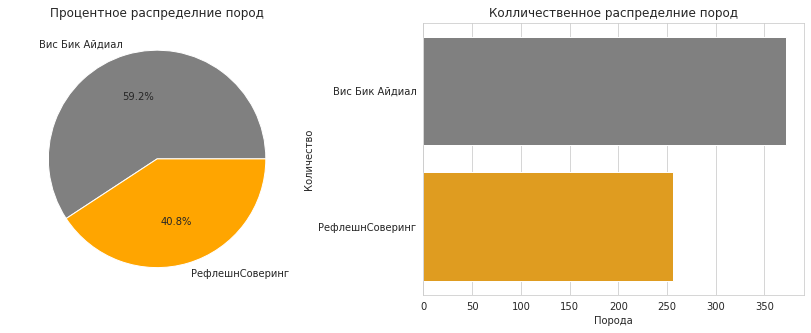

In [33]:
display(df_main['breed'].unique())
graph_cat(df_main, 'breed', 'распределние пород', 'Порода')

В данных представлены всего 2 породы значения в которых распределились с соотношением **40.7%** на **59.3%** , такое распределение не взывает подозрений.

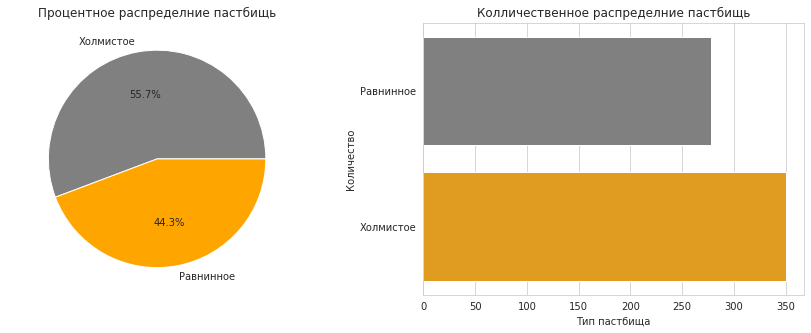

In [34]:
graph_cat(df_main, 'pasture', 'распределние пастбищь', 'Тип пастбища')

После исправления ошибки в названии типов пастбищ , данные выглядят нормально.

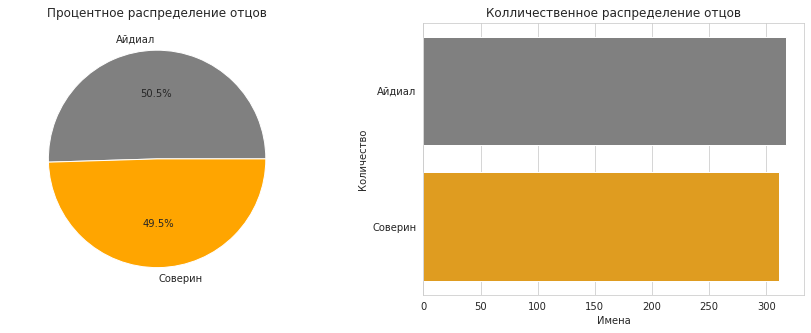

In [35]:
graph_cat(df_main, 'dad_type', 'распределение отцов', 'Имена')

В именах отцов , не наблюдается каких либо отклонений в данных.

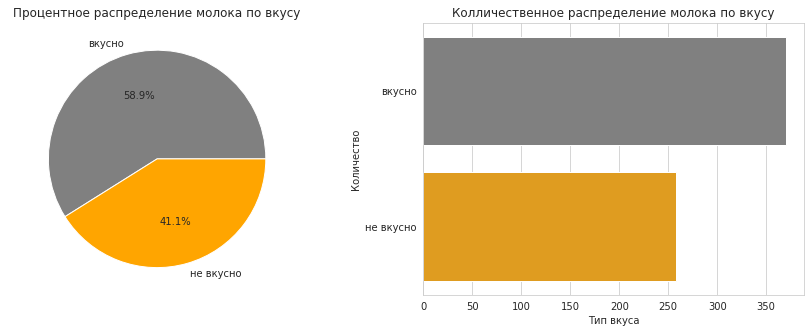

In [36]:
graph_cat(df_main, 'taste', 'распределение молока по вкусу', 'Тип вкуса')

Аномалий в данных о вкусе молока , так же не наблюдаеться.

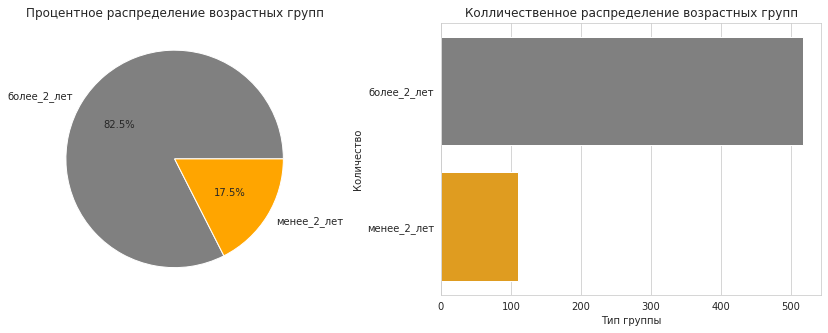

In [37]:
graph_cat(df_main, 'age_gr', 'распределение возрастных групп', 'Тип группы')

Видно значительное преобладание коров возрастом **более 2 лет**. Средняя продолжительность жизни коровы составляет порядка **20 лет** опираясь на эту информацию , данные выглядят правдоподобными.

#### Датафрейм `df_dad`

`df_dad` содержит всего 1 категориальную переменную.

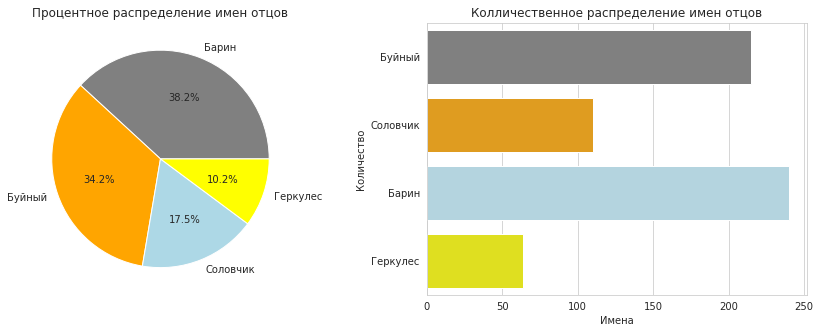

In [38]:
graph_cat(df_dad, 'dad_name', 'распределение имен отцов', 'Имена')

Данные подозрений не вызывают.

#### Датасет `df_cow`

Набор Данных обладет маленьким размером , поэтому возможна зрительная оценка качества данных.

In [39]:
df_cow

breed    pasture dad_type  dad_name   fat  protein       age_gr
0    Вис Бик Айдиал  Холмистое   Айдиал  Геркулес  3.58    3.076  более_2_лет
1    Вис Бик Айдиал  Равнинное  Соверин    Буйный  3.54    3.081  менее_2_лет
2   РефлешнСоверинг  Равнинное  Соверин     Барин  3.59    3.074  более_2_лет
3   РефлешнСоверинг  Холмистое   Айдиал    Буйный  3.40    3.061  более_2_лет
4   РефлешнСоверинг  Равнинное   Айдиал    Буйный  3.64    3.074  более_2_лет
5   РефлешнСоверинг  Равнинное  Соверин  Геркулес  3.63    3.053  менее_2_лет
6    Вис Бик Айдиал  Холмистое   Айдиал  Геркулес  3.58    3.076  более_2_лет
7    Вис Бик Айдиал  Равнинное  Соверин    Буйный  3.57    3.079  более_2_лет
8   РефлешнСоверинг  Равнинное  Соверин     Барин  3.59    3.074  более_2_лет
9   РефлешнСоверинг  Холмистое   Айдиал    Буйный  3.40    3.079  менее_2_лет
10   Вис Бик Айдиал  Холмистое  Соверин  Соловчик  3.73    3.055  более_2_лет
11  РефлешнСоверинг  Равнинное  Соверин  Геркулес  3.73    3.073  более_2_лет
12   Вис Бик Айдиал  Холмистое   Айдиал  Геркулес  3.68    3.046  более_2_лет
13   Вис Бик Айдиал  Холмистое  Соверин     Барин  3.42    3.075  менее_2_лет
14  РефлешнСоверинг  Равнинное  Соверин     Барин  3.59    3.074  более_2_лет
15  РефлешнСоверинг  Холмистое   Айдиал    Буйный  3.40    3.065  более_2_лет
16   Вис Бик Айдиал  Холмистое  Соверин  Соловчик  3.73    3.079  более_2_лет
17  РефлешнСоверинг  Равнинное  Соверин  Геркулес  3.77    3.053  менее_2_лет
18   Вис Бик Айдиал  Равнинное  Соверин    Буйный  3.34    3.069  более_2_лет
19  РефлешнСоверинг  Равнинное   Айдиал    Буйный  3.64    3.074  более_2_лет

Явных отклонений выявлено не было.

### Анализ числовых переменных

#### Набор данных `df_main`

**Переменная *milk_yeild***

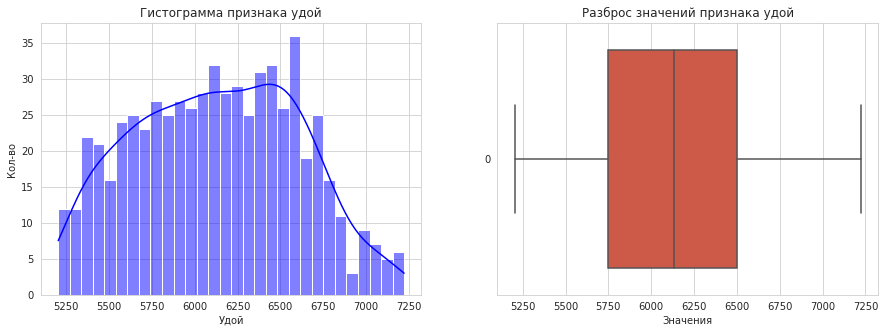

In [40]:
graph_num(df_main, 'milk_yeild', 'удой', 'Удой')

После удаления аномального значения на этапе предобработки , данные распределены нормально.

**Переменная *efu***

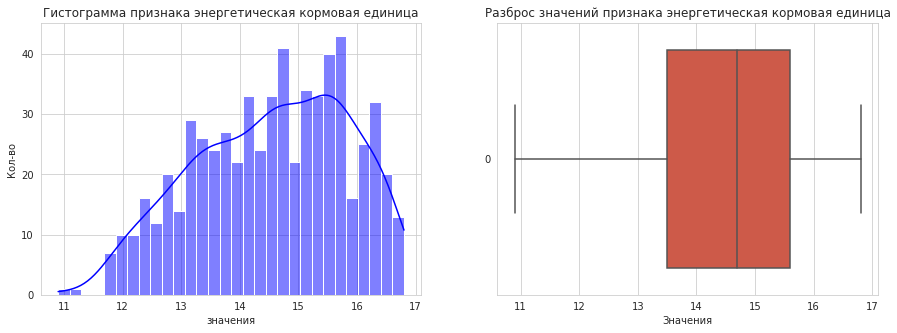

In [41]:
graph_num(df_main, 'efu', 'энергетическая кормовая единица', 'значения')

В анализе значений переменной `efu` аномалий не обнаружено.

**Переменная *raw_protein***

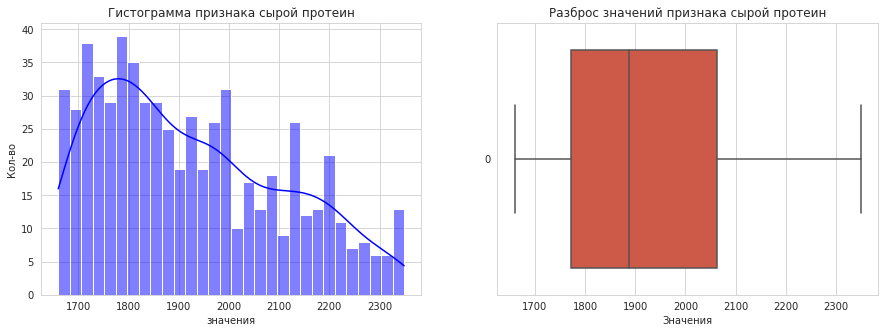

In [42]:
graph_num(df_main, 'raw_protein', 'сырой протеин', 'значения')

Выбросы и аномальные значения отсутствуют.

**Переменная *spr***

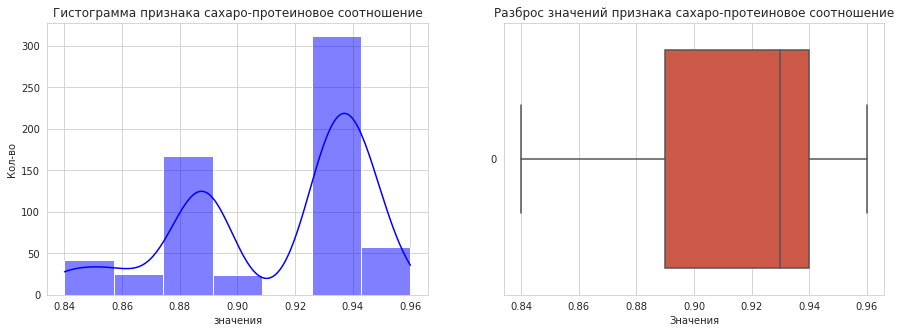

In [43]:
graph_num(df_main, 'spr', 'сахаро-протеиновое соотношение', 'значения', bins=7)

Данные переменной **spr** так же не содержат каких либо явных ошибок.

**Переменная *fat***

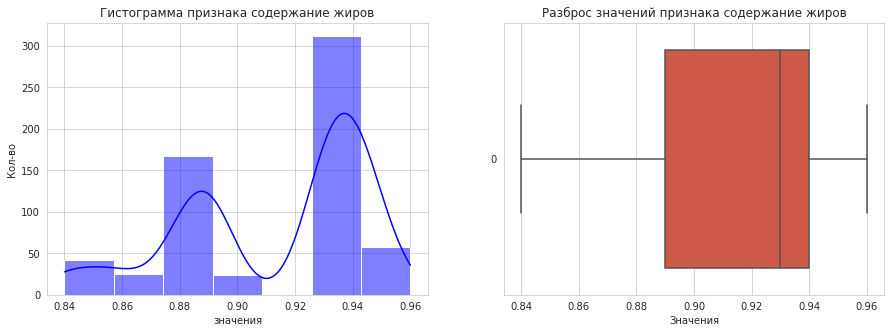

In [44]:
graph_num(df_main, 'spr', 'содержание жиров', 'значения', bins=7)

Учитывая маленький диапазон значений , данные выглядят нормально.

**Переменная *protein***

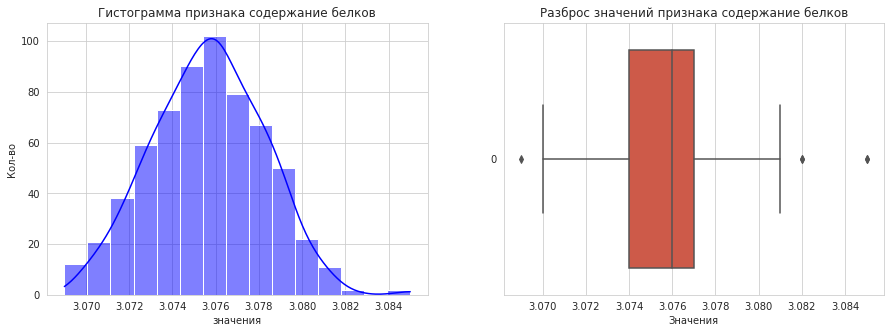

In [45]:
graph_num(df_main, 'protein', 'содержание белков', 'значения', bins=15)

На графике разброса значений обнаружилось несколько выбросов , но учитывая их малую погрешность в значениях оставим их в данных.

### Вывод

- На этапе предобработки мы устранили явные аномалии в данных и проанализировали на графиках категориальные и числовые переменные , каких либо явных аномалий выявлено не было , поэтому считаю что данные вполне готовы для обучения модели МО.


## Корреляционный анализ

Посмотрим на индексы корреляций в датасете `df_main` для оценки успешности построения модели.

Построим классическую матрицу корреляции *Cпирмана*

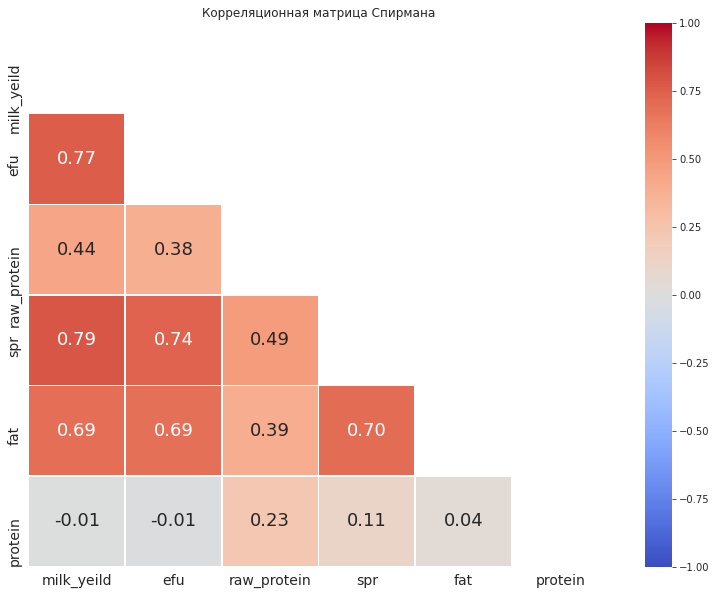

In [46]:
tri = np.triu(np.ones_like(df_main.drop('id', axis=1).corr(), dtype=bool))
plt.figure(figsize=(13, 10))
heatmap = sns.heatmap(
    df_main.drop('id', axis=1).corr('spearman'), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5,  
    vmin=-1, vmax=1, annot_kws={"size": 18}, mask=tri)     
plt.title("Корреляционная матрица Спирмана")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Воспользуемся библиотекой *phik* для построения матрицы для категориальных и числовых переменных.

interval columns not set, guessing: ['milk_yeild', 'efu', 'raw_protein', 'spr', 'fat', 'protein']


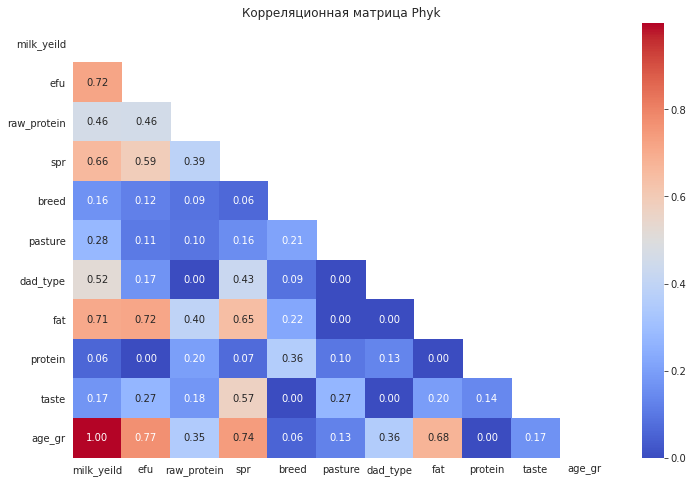

In [47]:
phik_matrix = df_main.drop('id', axis=1).phik_matrix()
tri = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=tri);
plt.title("Корреляционная матрица Phyk")
plt.show()

**Из таблиц корреляции видно что наш целевой признак *milk_yeild* сильней всего корелирует с *spr, efu***

**Построим диаграммы рассеивания для значений *milk_yeild* и всех численных переменных с поочередным указанием категориальных признаков в виде цвета точек.**

#### Категориальный признак породы коровы *breed*

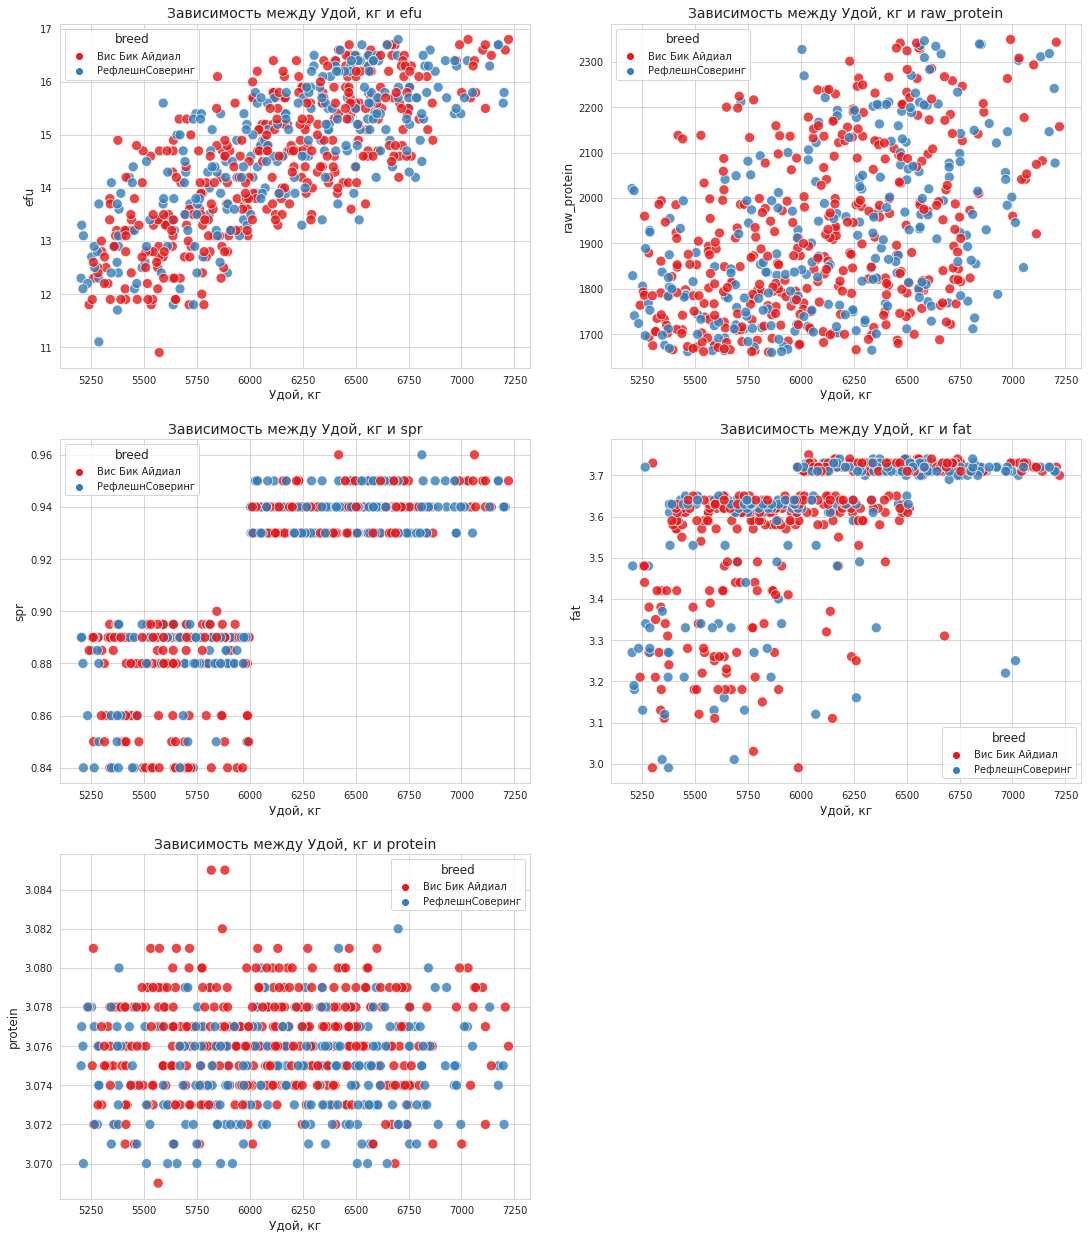

In [48]:
graph_scat(df_main, 'breed')

Какой либо сильной связи от типа породы , выявить не удалось.

#### Категориальный признак типа пастбища *pasture*

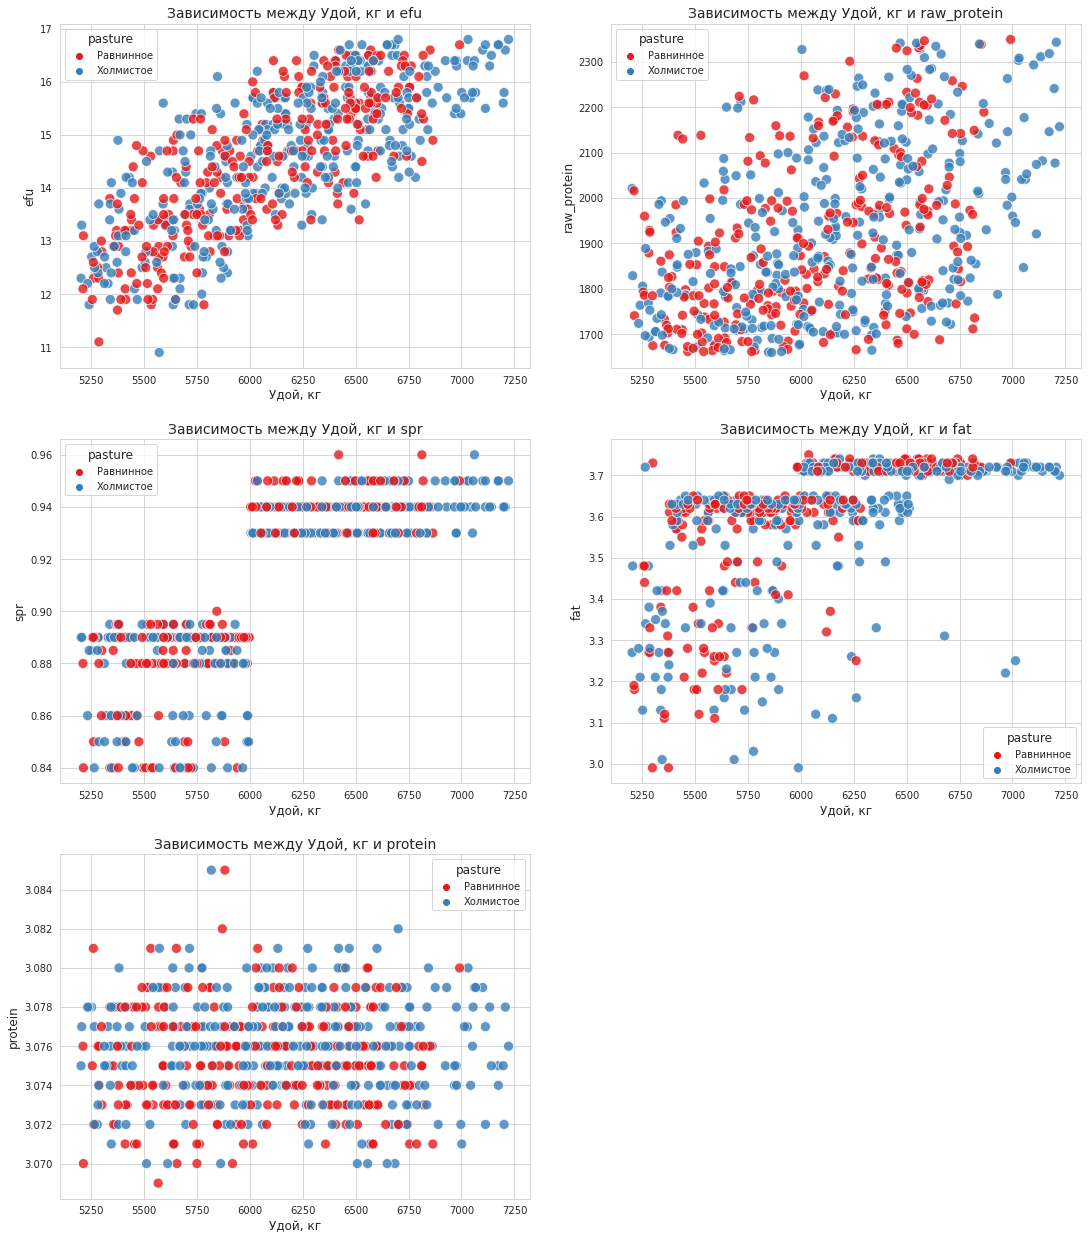

In [49]:
graph_scat(df_main, 'pasture')

Связи с типом пастбищ таж же не наблюдаеться.

#### Категориальный признак отца коровы *dad_type*

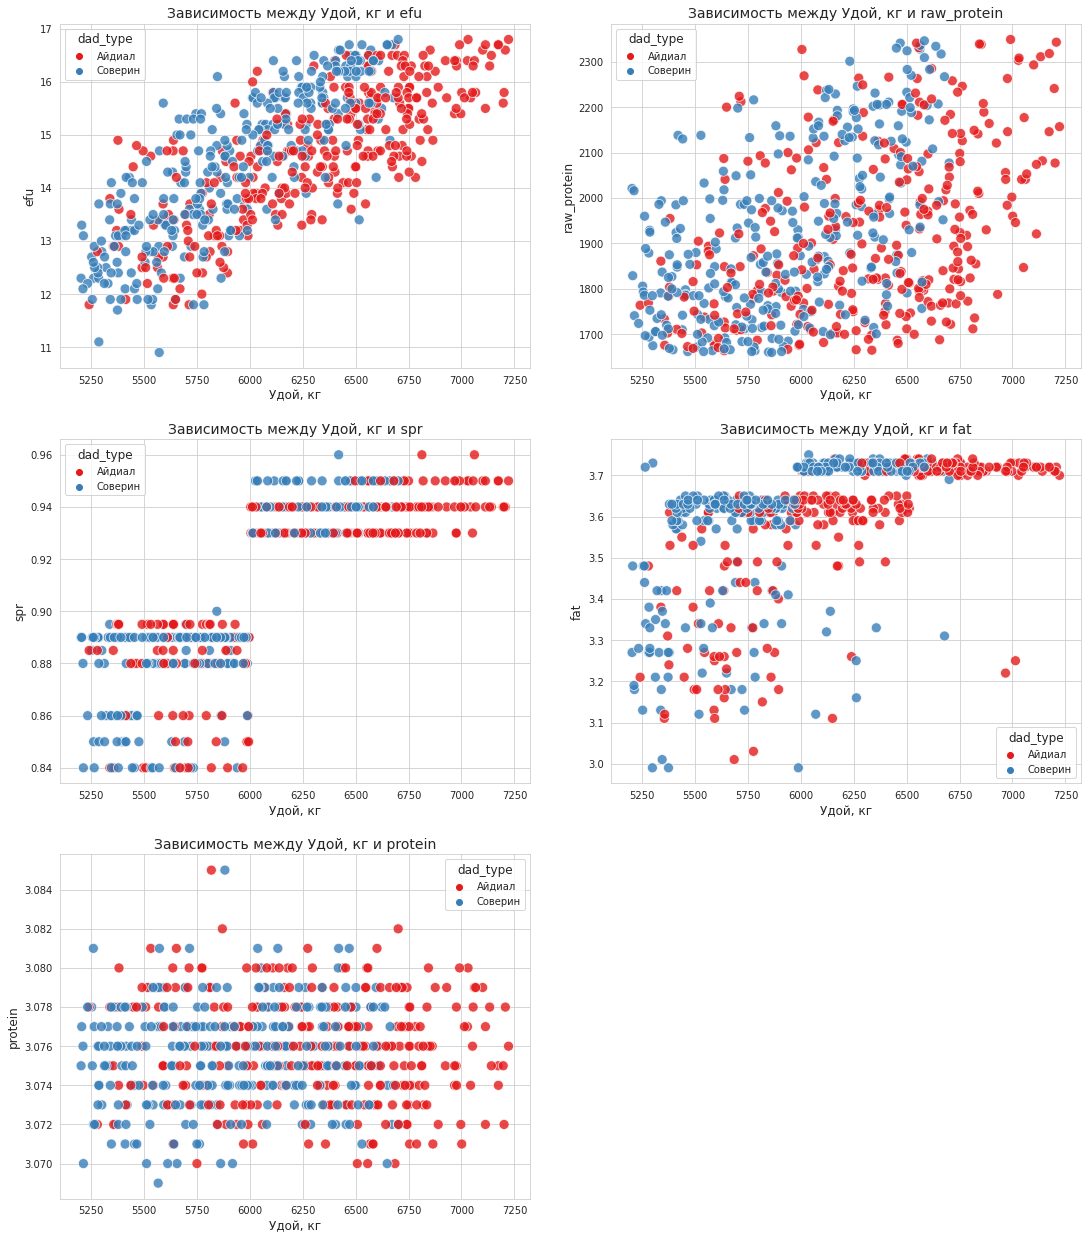

In [50]:
graph_scat(df_main, 'dad_type')

Наблюдаеться средняя корреляция с отцом коровы , видно что потомство от быка **Айдиал** в среднем показывает более лучшие результаты в получаемом удое.

#### Категориальный признак вкуса молока *taste*

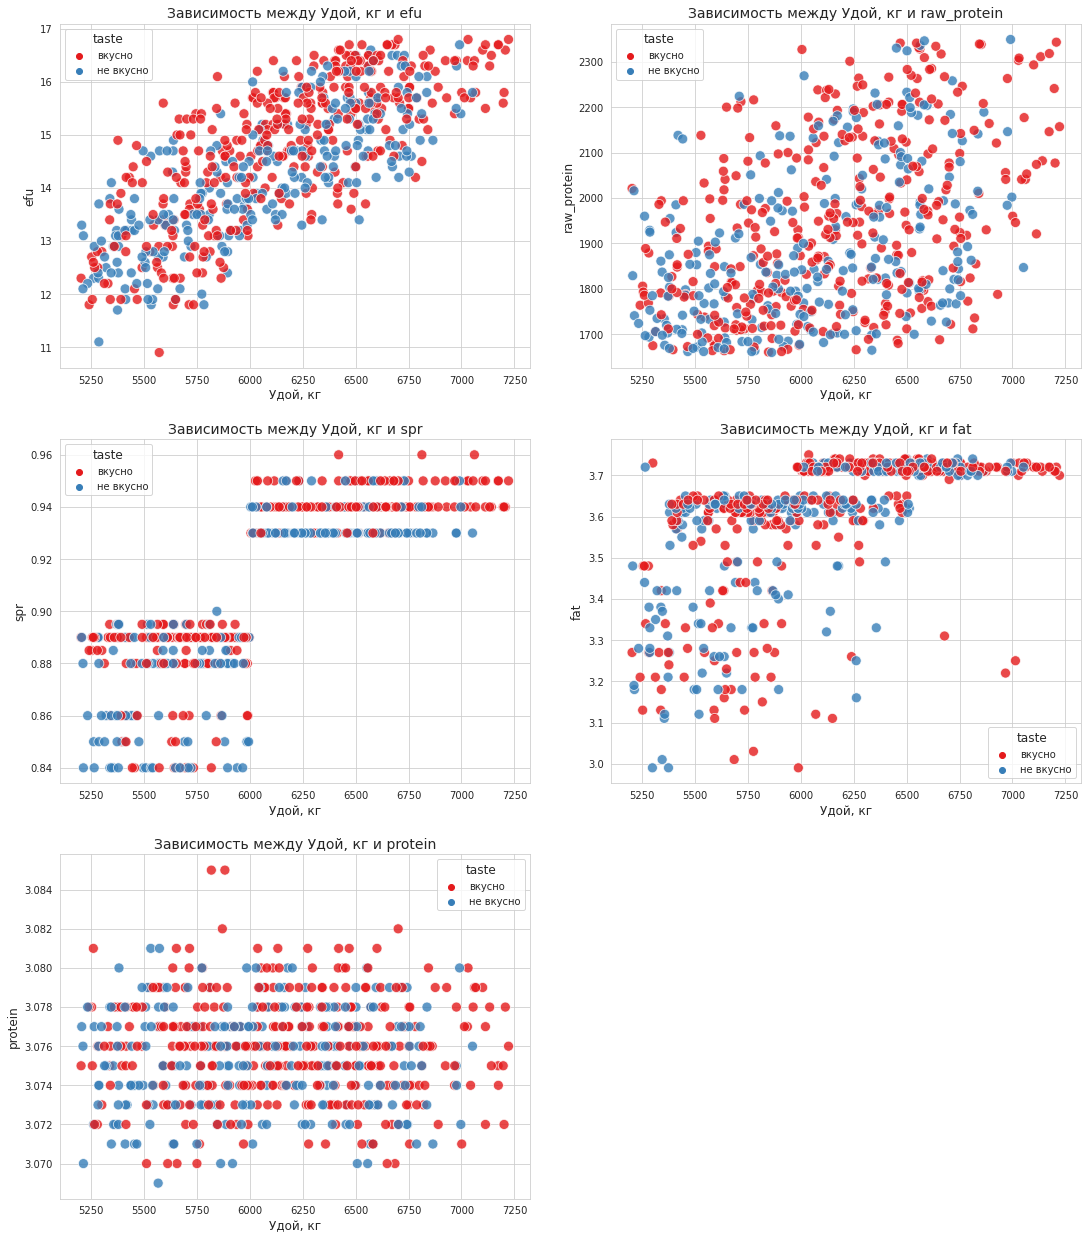

In [51]:
graph_scat(df_main, 'taste')

Наблюдаеться слабая связь получаемого удоя с конечным вкусом продукта, в среднем у коров с высоким удоем более вкусное молоко.

#### Категориальный признак возраста коровы *age_gr*

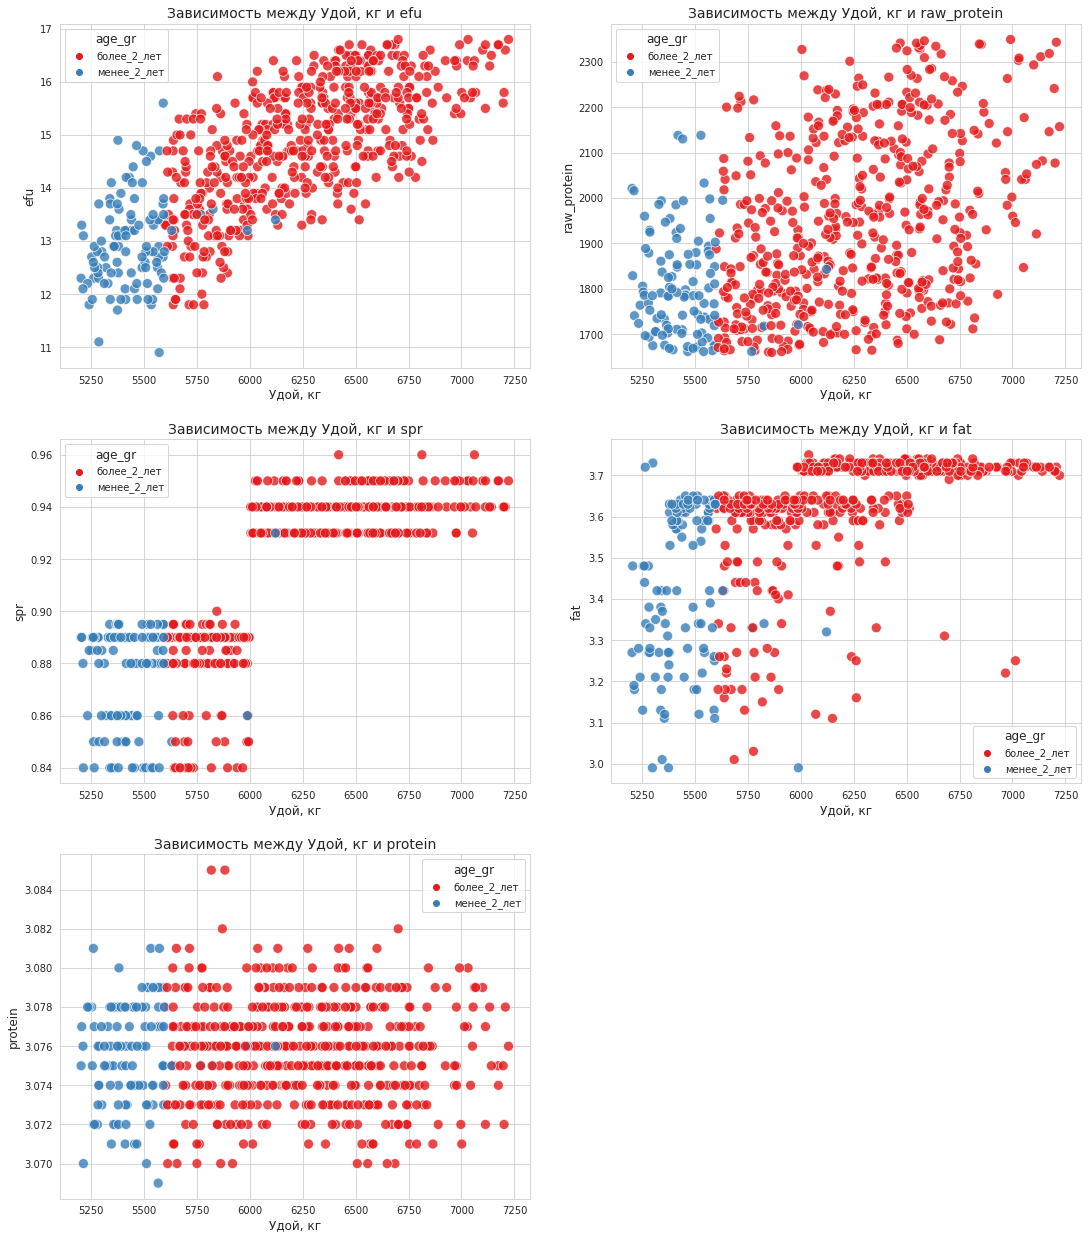

In [52]:
graph_scat(df_main, 'age_gr')

Наблюдается прямая зависимость удоя с возрастом коровы , так из диаграмм видно что коровы возрастом менее двух лет демонстрируют самые низкие показатели удоя.

### Вывод

- Из проведенного нами корреляционного анализа видно что наша целевая переменная `milk_yeild` связанна с переменными отвечающими за качество корма `spr, efu` и возрастом коровы `age_gr` , а так же наблюдается средняя связь с отцом коровы. Наблюдается так же связь с жирностью молока `fat` посмотрим далее сможем ли мы использовать эту переменную в построении модели МО.


- Между целевой переменной `milk_yeild` и `spr` наблюдаеться кластерная корреляция , значение `spr` в **0.9** можно считать их гранцей.

Мульти колинеальность fat и efu

## Обучение модели линейной регрессии

### Модель №1

Корреляционный и логический анализ показал что только числовая переменная из датасета `df_main` как **efu** имеет линейную связь с нашей целевой переменной , а так же категориальные переменные **pasture, dad_type, age_gr** с высоким значением корреляции , именно их и будем использовать для обучения модели.

Уберем из обучающего набора данных следующие переменные: **taste** как субъективную оценку вкуса молока фермером , анализом вкуса молока мы займемся в следующем блоке , столбец **id** как не несущий никакой ценной для модели МО информации, **breed, protein** из за низкой корреляции , **fat** как финальную характеристику оценки молока что не может влиять на нашу целевую переменную.


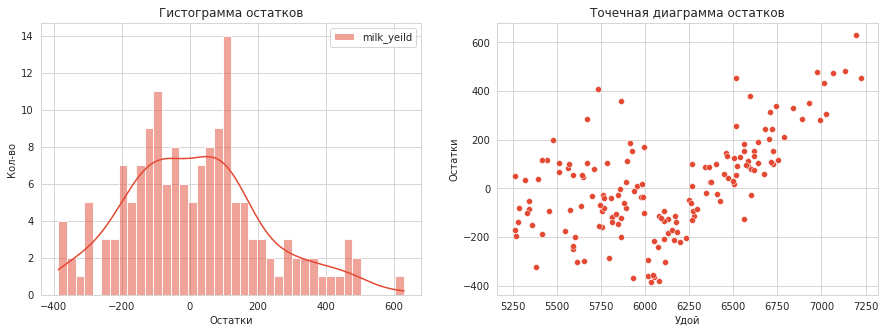

Успешность предсказания модели по метрике R2: 82.64%


In [53]:
# Создание выборок
df_main_clean = df_main.copy()
model_lr1 = LinearRegression()
rs = 69 # Значение random_state
encoder = OneHotEncoder(drop='first', sparse=False)
X1 = df_main.drop('milk_yeild', axis=1)
y1 = df_main['milk_yeild']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=rs)

# Категориальная кодировка
cat_names1 = ['pasture' ,'dad_type', 'age_gr']
X_train_ohe1 = encoder.fit_transform(X_train1[cat_names1])
X_test_ohe1 = encoder.transform(X_test1[cat_names1])
encoder_names1 = encoder.get_feature_names()

# Числовая кодировка
num_names1 = ['spr', 'efu']
scaler = StandardScaler()
X_train_scaled1 = scaler.fit_transform(X_train1[num_names1])
X_test_scaled1 = scaler.transform(X_test1[num_names1])

# Перевод np в pd
X_train_ohe1 = pd.DataFrame(X_train_ohe1, columns=encoder_names1)
X_test_ohe1 = pd.DataFrame(X_test_ohe1, columns=encoder_names1)
X_train_scaled1 = pd.DataFrame(X_train_scaled1)
X_test_scaled1 = pd.DataFrame(X_test_scaled1)
X_train1 = pd.concat([X_train_ohe1, X_train_scaled1], axis=1)
X_test1 = pd.concat([X_test_ohe1, X_test_scaled1], axis=1)
y_test1 = pd.DataFrame(y_test1)
# Обучение
model_lr1.fit(X_train1, y_train1)
y_pred1 = model_lr1.predict(X_test1)
#Метрики
r2_one1 = r2_score(y_test1, y_pred1)
y_pred1 = pd.DataFrame(y_pred1, columns=['milk_yeild'])  
y_test1 = y_test1.reset_index(drop=True)
residuals1 = y_test1 - y_pred1


fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(residuals1, bins=40, ax=ax[0], kde=True)
ax[0].set_title('Гистограмма остатков')
ax[0].set_xlabel('Остатки')
ax[0].set_ylabel('Кол-во')

sns.scatterplot(x=y_test1['milk_yeild'], y=residuals1['milk_yeild'], ax=ax[1])
ax[1].set_title('Точечная диаграмма остатков')
ax[1].set_xlabel('Удой')
ax[1].set_ylabel('Остатки')
plt.show()
print(f'Успешность предсказания модели по метрике R2: {round(r2_one1 * 100, 2)}%')

Мы построили первую модель МО , на предосталенных нам данных из датасета `df_main` , успешность предсказания составила **82.64%** что достаточно неплохо , а нализ остатков показал что после значения удоя в **6250** модель заваливаеться в сторону меньшего предсказания целевой переменной.

### Модель №2

Попытаемся повысить эффективность модели МО добавив в данные новые признаки. Введем переменную `spr_bin` которая будет выдавать бинарные значения по границе значения `spr` в **0.9** , больше 1 меньше 0.

А так же что бы повысить линейность признака `efu` добавим переменную `efu2` которая будет содержать квадрат значения `spr`.

In [54]:
def spr_count(value):
    if value > 0.9:
        return 1
    else:
        return 0
df_main['spr_bin'] = df_main['spr'].apply(spr_count)
df_main['efu2'] = df_main['efu'] ** 2
df_main.head(10)

id  milk_yeild   efu  raw_protein    spr            breed    pasture  \
0   1        5863  14.2         1743  0.890   Вис Бик Айдиал  Равнинное   
1   2        5529  12.8         2138  0.890   Вис Бик Айдиал  Равнинное   
2   3        5810  14.0         1854  0.885  РефлешнСоверинг  Холмистое   
3   4        5895  12.4         2012  0.885  РефлешнСоверинг  Холмистое   
4   5        5302  12.8         1675  0.885   Вис Бик Айдиал  Равнинное   
5   6        5254  12.7         1806  0.885  РефлешнСоверинг  Холмистое   
6   7        5910  13.2         1792  0.885   Вис Бик Айдиал  Равнинное   
7   8        6179  14.7         1806  0.930   Вис Бик Айдиал  Равнинное   
8   9        6783  14.2         1918  0.940  РефлешнСоверинг  Холмистое   
9  10        5339  13.4         1791  0.895   Вис Бик Айдиал  Холмистое   

  dad_type   fat  protein      taste       age_gr  spr_bin    efu2  
0   Айдиал  3.58    3.076     вкусно  более_2_лет        0  201.64  
1  Соверин  3.54    3.079     вкусно  менее_2_лет        0  163.84  
2  Соверин  3.59    3.074  не вкусно  более_2_лет        0  196.00  
3   Айдиал  3.40    3.075  не вкусно  более_2_лет        0  153.76  
4  Соверин  3.73    3.073     вкусно  менее_2_лет        0  163.84  
5  Соверин  3.13    3.078     вкусно  менее_2_лет        0  161.29  
6  Соверин  3.48    3.077     вкусно  более_2_лет        0  174.24  
7   Айдиал  3.55    3.076     вкусно  более_2_лет        1  216.09  
8   Айдиал  3.71    3.077     вкусно  более_2_лет        1  201.64  
9  Соверин  3.13    3.075     вкусно  менее_2_лет        0  179.56

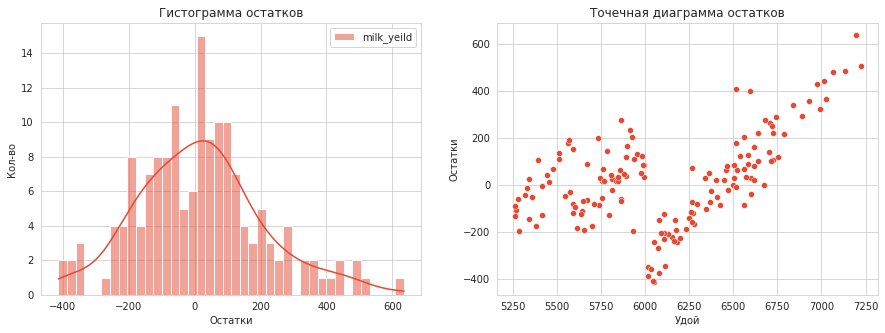

Успешность предсказания модели по метрике R2: 84.02%


In [55]:
# Создание выборок
model_lr2 = LinearRegression()
rs = 69 # Значение random_state
#encoder = OneHotEncoder(drop='first', sparse=False)
X2 = df_main.drop('milk_yeild', axis=1)
y2 = df_main['milk_yeild']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=rs)

# Категориальная кодировка
cat_names2 = ['pasture', 'dad_type', 'age_gr', 'spr_bin']
X_train_ohe2 = encoder.fit_transform(X_train2[cat_names2])
X_test_ohe2 = encoder.transform(X_test2[cat_names2])
encoder_names2 = encoder.get_feature_names()

# Числовая кодировка
num_names2 = ['spr', 'efu2']
#scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train2[num_names2])
X_test_scaled2 = scaler.transform(X_test2[num_names2])

# Перевод np в pd
X_train_ohe2 = pd.DataFrame(X_train_ohe2, columns=encoder_names2)
X_test_ohe2 = pd.DataFrame(X_test_ohe2, columns=encoder_names2)
X_train_scaled2 = pd.DataFrame(X_train_scaled2)
X_test_scaled2 = pd.DataFrame(X_test_scaled2)
X_train2 = pd.concat([X_train_ohe2, X_train_scaled2], axis=1)
X_test2 = pd.concat([X_test_ohe2, X_test_scaled2], axis=1)
y_test2 = pd.DataFrame(y_test2)
# Обучение
model_lr2.fit(X_train2, y_train2)
y_pred2 = model_lr2.predict(X_test2)
#Метрики
r2_one2 = r2_score(y_test2, y_pred2)
y_pred2 = pd.DataFrame(y_pred2, columns=['milk_yeild'])  
y_test2 = y_test2.reset_index(drop=True)
residuals2 = y_test2 - y_pred2


fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(residuals2, bins=40, ax=ax[0], kde=True)
ax[0].set_title('Гистограмма остатков')
ax[0].set_xlabel('Остатки')
ax[0].set_ylabel('Кол-во')

sns.scatterplot(x=y_test2['milk_yeild'], y=residuals2['milk_yeild'], ax=ax[1])
ax[1].set_title('Точечная диаграмма остатков')
ax[1].set_xlabel('Удой')
ax[1].set_ylabel('Остатки')
plt.show()
print(f'Успешность предсказания модели по метрике R2: {round(r2_one2 * 100, 2)}%')

Удалось повысить успешность предсказаний до **84.02%** , что на **~1.4%** больше чем в первой модели.

Остатки распределились значительно лучше относительно *Модели №1* , но после значения удоя в **6750** проявляеться тот же недостаток что и у первой модели.

### Модель №3

Попытаемся еще повысить точность модели , добавив в датафрейм имена отцов коров из стада фермера. Создав новый датасет.

In [56]:
df_main_final = pd.merge(df_main, df_dad, on='id', how='left')
df_main_final.head(5)

id  milk_yeild   efu  raw_protein    spr            breed    pasture  \
0   1        5863  14.2         1743  0.890   Вис Бик Айдиал  Равнинное   
1   2        5529  12.8         2138  0.890   Вис Бик Айдиал  Равнинное   
2   3        5810  14.0         1854  0.885  РефлешнСоверинг  Холмистое   
3   4        5895  12.4         2012  0.885  РефлешнСоверинг  Холмистое   
4   5        5302  12.8         1675  0.885   Вис Бик Айдиал  Равнинное   

  dad_type   fat  protein      taste       age_gr  spr_bin    efu2  dad_name  
0   Айдиал  3.58    3.076     вкусно  более_2_лет        0  201.64    Буйный  
1  Соверин  3.54    3.079     вкусно  менее_2_лет        0  163.84  Соловчик  
2  Соверин  3.59    3.074  не вкусно  более_2_лет        0  196.00     Барин  
3   Айдиал  3.40    3.075  не вкусно  более_2_лет        0  153.76    Буйный  
4  Соверин  3.73    3.073     вкусно  менее_2_лет        0  163.84     Барин

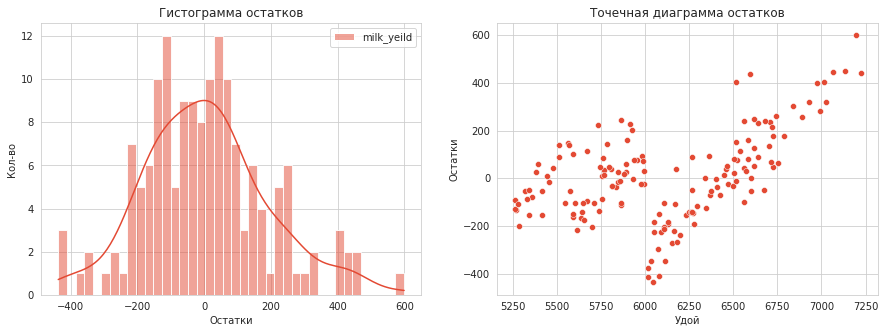

Успешность предсказания модели по метрике R2: 85.22%


In [57]:
# Создание выборок
model_lr3 = LinearRegression()
rs = 69 # Значение random_state
#encoder = OneHotEncoder(drop='first', sparse=False)
X3 = df_main_final.drop('milk_yeild', axis=1)
y3 = df_main_final['milk_yeild']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, random_state=rs)

# Категориальная кодировка
cat_names3 = ['pasture', 'dad_type', 'age_gr', 'spr_bin', 'dad_name']
X_train_ohe3 = encoder.fit_transform(X_train3[cat_names3])
X_test_ohe3 = encoder.transform(X_test3[cat_names3])
encoder_names3 = encoder.get_feature_names()

# Числовая кодировка
num_names3 = ['spr', 'efu2']
#scaler = StandardScaler()
X_train_scaled3 = scaler.fit_transform(X_train3[num_names3])
X_test_scaled3 = scaler.transform(X_test3[num_names3])

# Перевод np в pd
X_train_ohe3 = pd.DataFrame(X_train_ohe3, columns=encoder_names3)
X_test_ohe3 = pd.DataFrame(X_test_ohe3, columns=encoder_names3)
X_train_scaled3 = pd.DataFrame(X_train_scaled3)
X_test_scaled3 = pd.DataFrame(X_test_scaled3)
X_train3 = pd.concat([X_train_ohe3, X_train_scaled3], axis=1)
X_test3 = pd.concat([X_test_ohe3, X_test_scaled3], axis=1)
y_test3 = pd.DataFrame(y_test3)
# Обучение
model_lr3.fit(X_train3, y_train3)
y_pred3 = model_lr3.predict(X_test3)
#Метрики
r2_one3 = r2_score(y_test3, y_pred3)
y_pred3 = pd.DataFrame(y_pred3, columns=['milk_yeild'])  
y_test3 = y_test3.reset_index(drop=True)
residuals3 = y_test3 - y_pred3


fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(residuals3, bins=40, ax=ax[0], kde=True)
ax[0].set_title('Гистограмма остатков')
ax[0].set_xlabel('Остатки')
ax[0].set_ylabel('Кол-во')

sns.scatterplot(x=y_test3['milk_yeild'], y=residuals3['milk_yeild'], ax=ax[1])
ax[1].set_title('Точечная диаграмма остатков')
ax[1].set_xlabel('Удой')
ax[1].set_ylabel('Остатки')
plt.show()
print(f'Успешность предсказания модели по метрике R2: {round(r2_one3 * 100, 2)}%')

Из за добавления новых признаков , показания относительно предыдушей модели были улучшены на **~1.2%**.

Распределение остатков аналагично показаниям *Модели №2*

### Оценка успешности моделей

**Оценка по метрике R2**

In [58]:
print(f'Успешность предсказания модели №1 по метрике R2: {round(r2_one1 * 100, 2)}%')
print(f'Успешность предсказания модели №2 по метрике R2: {round(r2_one2 * 100, 2)}%')
print(f'Успешность предсказания модели №3 по метрике R2: {round(r2_one3 * 100, 2)}%')

Успешность предсказания модели №1 по метрике R2: 82.64%
Успешность предсказания модели №2 по метрике R2: 84.02%
Успешность предсказания модели №3 по метрике R2: 85.22%


**Оценки по метрикам MSE, MAE, RMSE**

In [59]:
df1 = model_score(y_test1, y_pred1, 1)
df2 = model_score(y_test2, y_pred2, 2)
df3 = model_score(y_test3, y_pred3, 3)

# Объединяем датафреймы в один
result_df = pd.concat([df1, df2, df3], ignore_index=True)
result_df

Model           MSE         MAE        RMSE
0  Model 1  40252.788863  159.652780  200.630977
1  Model 2  37055.823070  148.222374  192.498891
2  Model 3  34267.314700  142.781940  185.114329

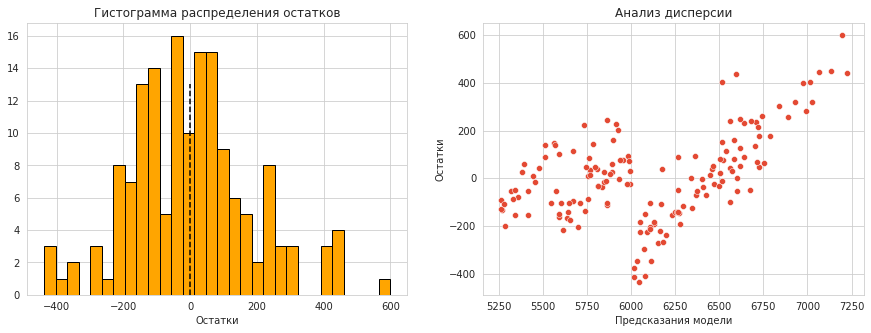

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(residuals3, bins=30, color='orange', edgecolor='black')
ax[0].vlines(x=0, colors='black', ymin=0, ymax=13, linestyles='--', label='Средняя сумма остатков')
ax[0].set_title('Гистограмма распределения остатков')
ax[0].set_xlabel('Остатки')

sns.scatterplot(x=y_test3['milk_yeild'], y=residuals3['milk_yeild'], ax=ax[1])
ax[1].set_xlabel('Предсказания модели')
ax[1].set_ylabel('Остатки')
ax[1].set_title('Анализ дисперсии')
plt.show()

**Определим доверительный интервал**

In [61]:
print('95% доверительный интервал =', st.norm.interval(confidence=0.95, 
                                                       loc=np.mean(y_train3), scale=st.sem(y_train3)))

95% доверительный интервал = (6086.749528185883, 6172.341766930889)


**Вывод**

Показатели метрик указывают на **модель №3** как более успешную в плане предсказаний. Анализ остатков показывает в целом нормальное распределение за исключением участка от **6750**.

Основная масса значений распределилась в диапозоне **от 6086 до 6172** по переменной `milk_yeild`

### Предсказание *удоя* на данных присланных «ЭкоФерма»

Добавим недостающие признаки в датасет `df_cow` , возмем средние значения таких переменных как `efu, raw_protein, spr` из датафрейма `df_main`, так же нам известно что продавец увеличил характеристики связнные с кормлением на **5%**

In [62]:
df_cow['efu'] = (df_main['efu'].mean() * 1.05).round(1)
df_cow['raw_protein'] = int((df_main['efu'].mean() * 1.05))
df_cow['spr'] = (df_main['spr'].mean() * 1.05).round(3)
df_cow['spr_bin'] = df_cow['spr'].apply(spr_count)
df_cow['efu2'] = df_cow['efu'] ** 2


In [63]:
# Категориальная кодировка
cat_names = ['pasture', 'dad_type', 'age_gr', 'spr_bin', 'dad_name']
X_train_ohec = encoder.transform(df_cow[cat_names]) 
encoder_cow = encoder.get_feature_names(cat_names)  

# Числовая кодировка
num_names = ['spr', 'efu2']
X_train_scaledc = scaler.transform(df_cow[num_names])

# Преобразуем в DataFrame
X_train_ohec = pd.DataFrame(X_train_ohec, columns=encoder_cow)  
X_train_scaledc = pd.DataFrame(X_train_scaledc)  

# Объединяем данные
df_cow_pred = pd.concat([X_train_ohec, X_train_scaledc], axis=1)

# Предсказание
predictions = model_lr3.predict(df_cow_pred)
pred = pd.DataFrame(predictions)
df_c = pd.merge(left=df_cow, right=pred, right_index=True, left_index=True)
df_c = df_c.rename(columns={0: 'pred_milk_yeild'})
#df_c.drop(16, inplace=True)
df_c[df_c['pred_milk_yeild'] > 6000]

breed    pasture dad_type  dad_name   fat  protein       age_gr  \
0    Вис Бик Айдиал  Холмистое   Айдиал  Геркулес  3.58    3.076  более_2_лет   
1    Вис Бик Айдиал  Равнинное  Соверин    Буйный  3.54    3.081  менее_2_лет   
2   РефлешнСоверинг  Равнинное  Соверин     Барин  3.59    3.074  более_2_лет   
3   РефлешнСоверинг  Холмистое   Айдиал    Буйный  3.40    3.061  более_2_лет   
4   РефлешнСоверинг  Равнинное   Айдиал    Буйный  3.64    3.074  более_2_лет   
5   РефлешнСоверинг  Равнинное  Соверин  Геркулес  3.63    3.053  менее_2_лет   
6    Вис Бик Айдиал  Холмистое   Айдиал  Геркулес  3.58    3.076  более_2_лет   
7    Вис Бик Айдиал  Равнинное  Соверин    Буйный  3.57    3.079  более_2_лет   
8   РефлешнСоверинг  Равнинное  Соверин     Барин  3.59    3.074  более_2_лет   
9   РефлешнСоверинг  Холмистое   Айдиал    Буйный  3.40    3.079  менее_2_лет   
10   Вис Бик Айдиал  Холмистое  Соверин  Соловчик  3.73    3.055  более_2_лет   
11  РефлешнСоверинг  Равнинное  Соверин  Геркулес  3.73    3.073  более_2_лет   
12   Вис Бик Айдиал  Холмистое   Айдиал  Геркулес  3.68    3.046  более_2_лет   
13   Вис Бик Айдиал  Холмистое  Соверин     Барин  3.42    3.075  менее_2_лет   
14  РефлешнСоверинг  Равнинное  Соверин     Барин  3.59    3.074  более_2_лет   
15  РефлешнСоверинг  Холмистое   Айдиал    Буйный  3.40    3.065  более_2_лет   
16   Вис Бик Айдиал  Холмистое  Соверин  Соловчик  3.73    3.079  более_2_лет   
17  РефлешнСоверинг  Равнинное  Соверин  Геркулес  3.77    3.053  менее_2_лет   
18   Вис Бик Айдиал  Равнинное  Соверин    Буйный  3.34    3.069  более_2_лет   
19  РефлешнСоверинг  Равнинное   Айдиал    Буйный  3.64    3.074  более_2_лет   

     efu  raw_protein    spr  spr_bin    efu2  pred_milk_yeild  
0   15.3           15  0.959        1  234.09      6599.790652  
1   15.3           15  0.959        1  234.09      6332.511011  
2   15.3           15  0.959        1  234.09      6295.571978  
3   15.3           15  0.959        1  234.09      6579.295944  
4   15.3           15  0.959        1  234.09      6521.296498  
5   15.3           15  0.959        1  234.09      6353.005718  
6   15.3           15  0.959        1  234.09      6599.790652  
7   15.3           15  0.959        1  234.09      6553.487543  
8   15.3           15  0.959        1  234.09      6295.571978  
9   15.3           15  0.959        1  234.09      6358.319412  
10  15.3           15  0.959        1  234.09      6399.753238  
11  15.3           15  0.959        1  234.09      6573.982250  
12  15.3           15  0.959        1  234.09      6599.790652  
13  15.3           15  0.959        1  234.09      6132.594891  
14  15.3           15  0.959        1  234.09      6295.571978  
15  15.3           15  0.959        1  234.09      6579.295944  
16  15.3           15  0.959        1  234.09      6399.753238  
17  15.3           15  0.959        1  234.09      6353.005718  
18  15.3           15  0.959        1  234.09      6553.487543  
19  15.3           15  0.959        1  234.09      6521.296498

### Вывод

- Мы поочередно обучили 3 модели МО для предсказания количественного удоя коров на данных фермера , обогащая каждую следующую модель новыми данными.


- После проделанной работы и оценки метрик мы остановились на **модели №3** как более эффективной на фоне других.


- Мы проверили работу модели на реальных данных из «ЭкоФерма» , и модель рекомендует **всех** коров к покупке по признаку получаемого молока.


## Обучение модели логистической регрессии

Посмотрим на значения корреляции наших обогащенных данных.

interval columns not set, guessing: ['milk_yeild', 'efu', 'raw_protein', 'spr', 'fat', 'protein', 'spr_bin', 'efu2']


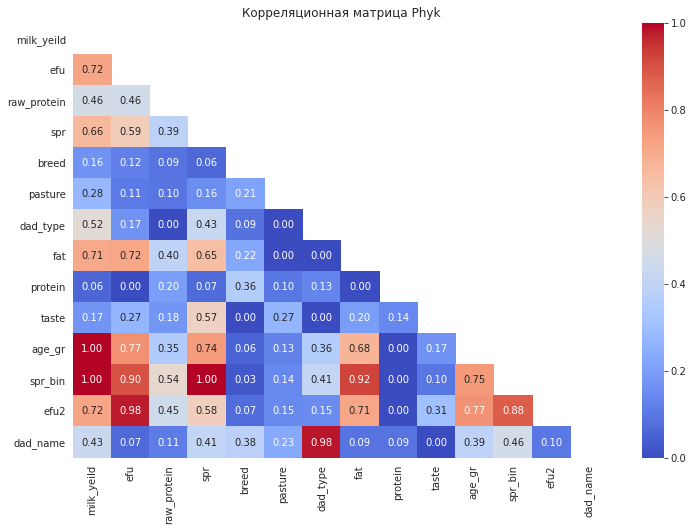

In [64]:
phik_matrix = df_main_final.drop('id', axis=1).phik_matrix()
tri = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=tri);
plt.title("Корреляционная матрица Phyk")
plt.show()

Одной из задач поставленных заказчиком , предсказать вкус молока коровы , которую он планирует купить. Обучим модель логистической регрессии для выполнения этой задачи. Добавим в обучение признаки которые могут повлиять на вкус молока `protein, fat`

precision    recall  f1-score     support
0              0.375000  0.290323  0.327273   62.000000
1              0.596330  0.684211  0.637255   95.000000
accuracy       0.528662  0.528662  0.528662    0.528662
macro avg      0.485665  0.487267  0.482264  157.000000
weighted avg   0.508926  0.528662  0.514842  157.000000

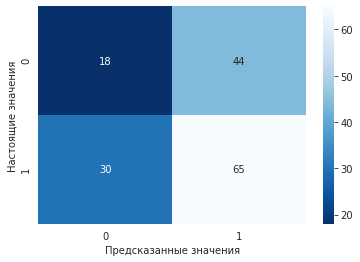

In [65]:
encoder = OneHotEncoder()
scaler = StandardScaler()
X_log = df_main_final.drop(columns='taste')
y_log = df_main_final['taste']
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_log, y_log, random_state=rs)

cat_names = ['pasture', 'age_gr', 'spr_bin']
X_train4_ohe = encoder.fit_transform(X_train4[cat_names])
X_test4_ohe = encoder.transform(X_test4[cat_names])
encoder_names4 = encoder.get_feature_names()

num_names = ['efu2', 'protein', 'fat']
X_train4_scaled = scaler.fit_transform(X_train4[num_names])
X_test4_scaled = scaler.transform(X_test4[num_names])

X_train4_ohe = pd.DataFrame(X_train4_ohe.toarray(), columns=encoder_names4)  
X_test4_ohe = pd.DataFrame(X_test4_ohe.toarray(), columns=encoder_names4)
X_train4_scaled = pd.DataFrame(X_train4_scaled, columns=num_names)  
X_test4_scaled = pd.DataFrame(X_test4_scaled, columns=num_names)
X_train4 = pd.concat([X_train4_ohe, X_train4_scaled], axis=1)
X_test4 = pd.concat([X_test4_ohe, X_test4_scaled], axis=1)

clf = LogisticRegression()
clf = clf.fit(X_train4, y_train4)

y_pred4 = clf.predict(X_test4)

#accuracy = accuracy_score(y_test4, y_pred4)
# recall = recall_score(y_test4, y_pred4)
#precision = precision_score(y_test4, y_pred4,pos_label='вкусно')
y_pred4 = (y_pred4 == "вкусно").astype(int)
y_test4 = (y_test4 == "вкусно").astype(int)
clas = classification_report(y_test4, y_pred4, output_dict=True)
cm = confusion_matrix(y_test4, y_pred4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения');
clas = pd.DataFrame(clas).T
clas


Модель научилась предсказывать верный результат всего в **52%** случаев , что крайне мало. Оптимизируем её для наших задач ниже.

### Анализ модели логистической регрессии

Преимущественной задачей для заказчика является приобретение коров дающих вкусное молоко , поэтому приобретение ошибочно классифицированных коров (Ошибка первого рода (False Positive, FP) являться для фермера более критическим.

Попытаемся найти и установить оптимальное значение порога классификации,  что бы снизить количество неверных предсказаний.
Для этого построим график зависимости *precision_recall_curve* , а так же переберем подходящие пороги и вернем в исходный код нужное нам значение.


In [66]:
y_proba = clf.predict_proba(X_test4)[:, 0]

thresholds = np.arange(0.1, 1.0, 0.01)

precisions = [precision_score(y_test4, y_proba >= t, zero_division=0) for t in thresholds]

optimal_threshold = thresholds[np.argmax(precisions)]
print(f"Оптимальный порог для максимизации точности: {optimal_threshold}")


Оптимальный порог для максимизации точности: 0.8199999999999996


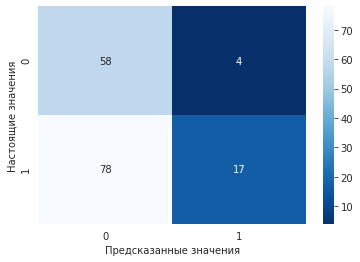

precision    recall  f1-score     support
0              0.426471  0.935484  0.585859   62.000000
1              0.809524  0.178947  0.293103   95.000000
accuracy       0.477707  0.477707  0.477707    0.477707
macro avg      0.617997  0.557216  0.439481  157.000000
weighted avg   0.658254  0.477707  0.408714  157.000000

In [67]:
threshold = 0.82

y_true4 = (y_test4 == "вкусно").astype(int)
y_pred_new = (y_proba >= threshold).astype(int)

cm = confusion_matrix(y_test4, y_pred_new)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')
plt.show()

clas = classification_report(y_test4, y_pred_new, output_dict=True)
clas = pd.DataFrame(clas).T
clas

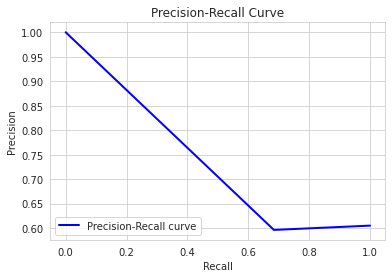

In [68]:
precision, recall, thresholds = precision_recall_curve(y_test4, y_pred4)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### Вывод

- Мы обучили модель логистической регрессии для предсказания вкуса молока , для задачи заказчика приоритетным выступал фактор снижения ошибок *Ошибка первого рода (False Positive, FP)* 


- Мы нашли и установили порог классификации в **0.82** что позволило нам повысить показания метрики precision до **0.80** и получить на тестовой выборке всего одно неверное предсказание.


### Предсказание вкуса молока на данных присланных «ЭкоФерма»

Добавим в ранее созданный на этапе линейной регрессии датафрейм данные которые могут повлиять на вкус молока.

In [73]:
cat_names = ['pasture', 'age_gr', 'spr_bin']
X_train_ohec = encoder.transform(df_cow[cat_names])  
encoder_cow = encoder.get_feature_names(cat_names)  

num_names = ['efu2', 'protein', 'fat']
X_train_scaledc = scaler.transform(df_cow[num_names])  

X_train_ohec = pd.DataFrame(X_train_ohec.toarray(), columns=encoder_cow)  
X_train_scaledc = pd.DataFrame(X_train_scaledc, columns=num_names)  

df_cow_pred = pd.concat([X_train_ohec, X_train_scaledc], axis=1)

Установим обнаруженный нами порог классификации в **0.82**

In [83]:
y_proba_f = clf.predict_proba(df_cow_pred)[:, 0]
predictions_final = (y_proba_f > 0.82).astype(int)
predictions_final

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

При столь высоком пороге , модель не рекомендует к покупке не одну из коров по признаку вкуса молока.

Понизим это значение до порога в **0.75**

In [86]:
y_proba_f = clf.predict_proba(df_cow_pred)[:, 0]
predictions_final = (y_proba_f > 0.75).astype(int)
predictions_final

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

Как видим модель предложила двух кандидатов для покупки в зависимости от вкуса молока.

Обьеденим эти данные с ранее полученными показателями удоя.

### Вывод

- Мы обучили модель МО для предсказания вкуса молока , базовая версия имела следующие метрики `accuracy` = **58%** и метрику precision для оценки ошибок первого рода в **0.62**


- Выполняя поставленные заказчиком задачи мы изменили порог классификации до **0.82** , что позволило повысить метрику precession до **0.80**


- При предсказании на реальных данных присланных «ЭкоФерма» , этот порог оказался слишком высок и мы опустили его к значениям в **0.75**

## Итоговые выводы

**Объединим предсказанные данные линейной и логистической регрессии**

In [90]:
predictions_final = pd.DataFrame(predictions_final)
final_predict = pd.concat([df_c, predictions_final], axis=1)
final_predict.rename(columns={0: 'pred_taste'}, inplace=True)
final_predict.query('(pred_milk_yeild > 6000) & (pred_taste == 1)')

breed    pasture dad_type  dad_name   fat  protein       age_gr  \
9   РефлешнСоверинг  Холмистое   Айдиал    Буйный  3.40    3.079  менее_2_лет   
16   Вис Бик Айдиал  Холмистое  Соверин  Соловчик  3.73    3.079  более_2_лет   

     efu  raw_protein    spr  spr_bin    efu2  pred_milk_yeild  pred_taste  
9   15.3           15  0.959        1  234.09      6358.319412           1  
16  15.3           15  0.959        1  234.09      6399.753238           1

### Вывод по покупке

Комбинация линейной и логистической регрессии , для максимальной оптимизации издержек , рекомендует из представленных в данных  «ЭкоФерма» две коровы в индексом **9 и 16**.

### Обзорные выводы

**Заказчик поставил задачу из данных присланных фирмой *«ЭкоФерма»* отобрать коров которые будут удовлетворять двум признакам : молоко должно быть вкусным и удой за год должен превышать 6000кг.**

Вот что мы проделали :

- Мы получили 3 набора данных , загрузив их мы обнаружили один и тот же дефект , переменные были записаны с применением разных языков и регистра , так же при первичном ознакомлении были обнаружены некоторые выбивающиеся значения.


- На этапе предобработки , мы привели все наборы данных в одному стилю оформления , так же попутно устранив дубликаты и опечатки в переменных и ошибочно записанные числовые переменные.


- На этапе статистического анализа мы построили графики всех переменных что бы проверить эффективность выполненной предобработки. По итогу блока , данные вполне удовлетворяют условиям и готовы к обучению модели.


- При проведении корреляционного анализа нашей целевой переменной `milk_yeild` удалось установить что она обладает сильной связью с такими переменными как `spr, efu, age_gr`


- При обучении модели линейной регрессии для предсказания количественного признака `milk_yeild` на первом этапе мы получили слабую модель с оценкой эффективности по метрике r2 в **82%** что значит что в **18%** давала ошибочный прогноз. Мы начали постепенное обогащение наших данных новыми признаками и в итоге в **модели №3** удалось добиться куда более внушительных результатов по r2 в **85%**


- При решении задачи предсказания вкуса молока в обучение были добавлены новые числовые переменные `protein, fat` которые не участвовали в модели линейной регрессии , но могут влиять на вкус молока. При получении предсказаний мы получили модель со слабым предсказательным потенциалом метрика **accuracy** балы на уровне **52%** , но выполняя задачу заказчика мы сконцентрировались на предсказаниях *ошибки первого рода* и достигли значительных успехов снизив вероятность ошибки предсказаний коровы дающей вкусное молоко до **80%**. Но на этапе работы на реальных данных этот порог оказался слишком высок и было принято решении о его снижении до показаний в **0.75**

